# Entrega 3, Grupo 02 - Aprendizaje por Refuerzos

- Santiago Alaniz,  5082647-6, santiago.alaniz@fing.edu.uy
- Bruno De Simone,  4914555-0, bruno.de.simone@fing.edu.uy
- María Usuca,      4891124-3, maria.usuca@fing.edu.uy

Modulo util para graficar los datos

In [3]:
import numpy as np
import matplotlib.pyplot as plt

def calcular_promedios(iteraciones, penalizaciones):
    print(f"Se realizaron {np.mean(iteraciones)} iteraciones, en promedio")
    print(f"Se recibieron {np.mean(penalizaciones)} penalizaciones, en promedio")

def dibujar_grafico(episodios, datos, subindice, etiqueta_y, titulo, color='blue', escala_log_x=False, escala_log_y=False):
    plt.subplot(3, 1, subindice)
    plt.plot(episodios, datos, color=color)
    
    plt.xlabel('Episodio')
    plt.ylabel(etiqueta_y)
    plt.title(titulo)
    
    if escala_log_x: plt.xscale('log')
    if escala_log_y: plt.yscale('log')

    plt.grid(True)

Importamos la biblioteca Gymnassium, que vamos a usar como framework de RL

In [4]:
!pip3 install cmake gymnasium scipy
import gymnasium as gym

Creamos un ambiente y lo mostramos en pantalla. Para esto definimos una función para imprimir nuestro ambiente.

In [5]:
# La semilla usada para crear el ambiente
semilla = 1

entorno = gym.make("Taxi-v3", render_mode='ansi').env
entorno.reset(seed = semilla)

# Una funcion de ayuda para imprimir el estado de nuestro mundo
def print_env(estado):
  env_str = estado.render()
  print(env_str)

print_env(entorno)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+





El rectángulo de color representa el taxi, amarillo cuando va sin pasajero y verde con pasajero.
'|' representa una pared que el taxi no puede cruzar, es decir.
R, G, Y, B son los puntos de interés, es decir, las posibles ubicaciones de recogida y destino. La letra azul representa la ubicación actual de recogida de pasajeros, y la letra púrpura es el destino actual.

Si cambiamos la semilla, cambia el estado del ambiente.

In [115]:
# Una semilla diferente
semilla = 2

entorno = gym.make("Taxi-v3", render_mode='ansi').env
entorno.reset(seed = semilla)

print_env(entorno)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+




Exploremos el espacio de estados y de acciones:

In [7]:
print(f"Espacio de Acciones {entorno.action_space}")
print(f"Espacio de Estados {entorno.observation_space}")

Espacio de Acciones Discrete(6)
Espacio de Estados Discrete(500)


Hay 6 acciones, que corresponden a:
 * 0 = ir al Sur
 * 1 = ir al Norte
 * 2 = ir al Este
 * 3 = ir al Oeste
 * 4 = recoger pasajero
 * 5 = dejar pasajero

Los puntos cardinales siguen la convención Norte hacia arriba. Recoger/dejar al pasajero solo tienen efecto si el taxi está en la misma casilla que el pasajero, y en uno de los puntos de interés.

Nuestro agente deberá elegir la acción a tomar en cada paso. Gymnassium nos expone funciones para esto. Si queremos movernos al sur, por ejemplo:

In [8]:
semilla = 1
entorno = gym.make("Taxi-v3", render_mode='ansi').env
entorno.reset(seed = semilla)
print_env(entorno)

accion = 0 # Sur
entorno.step(accion)

print_env(entorno)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+


+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)



Ahora estamos listos para programar un agente. Empezando por uno random. Se puede ejecutar el codigo abajo varias veces para ver como cambia en cada ejecución.

In [9]:
import random 

def episodio_random(semilla_ambiente = 1):
    entorno = gym.make("Taxi-v3", render_mode='ansi').env
    entorno.reset(seed = semilla_ambiente)

    iteraciones = 0
    penalizaciones, recompensa = 0, 0

    marcos = [] # para la animación

    termino = False
    truncado = False

    while not termino and not truncado:
        #  selecciona una acción aleatoria del conjunto de todas las posibles acciones
        accion = entorno.action_space.sample() 
        estado, recompensa, termino, truncado, info = entorno.step(accion)

        # El agente trato de dejar/recoger al pasajero incorrectamente
        if recompensa == -10:
            penalizaciones += 1

        # Put each rendered frame into dict for animation
        marcos.append({
            'marco': entorno.render(),
            'estado': estado,
            'accion': accion,
            'recompensa': recompensa
            }
        )

        iteraciones += 1


    print(f"Iteraciones: {iteraciones}")
    print(f"Penalizaciones: {penalizaciones}")

    return marcos

marcos = episodio_random()

Iteraciones: 6858
Penalizaciones: 2246


Podemos ver el episodio completo abajo. Notar que seleccionamos la semillia de selector de acciones para que la corrida sea 'buena'.

In [10]:
from IPython.display import clear_output
from time import sleep
import sys

def print_frames(marcos, delay=0.01):
    for i, marco in enumerate(marcos):
        clear_output()
        print(marco['marco'])
        print(f"Iteracion: {i + 1}")
        print(f"Estado: {marco['estado']}")
        print(f"Accion: {marco['accion']}")
        print(f"Recompensa: {marco['recompensa']}")
        sys.stdout.flush()
        # Aumentar este tiempo para ver mejor la animación
        sleep(delay)

print_frames(marcos)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)

Iteracion: 6858
Estado: 0
Accion: 5
Recompensa: 20


Ahora queremos programar un agente inteligente, para eso nos vamos a atener a la siguiente interfaz.

In [11]:
class Agente:
    def elegir_accion(self, estado, max_accion) -> int:
        """Elegir la accion a tomar en el estado actual y el espacio de acciones"""
        pass

    def aprender(self, estado_anterior, estado_siguiente, accion, recompensa):
        """Aprender a partir de la tupla 
            - estado_anterior: el estado desde que se empezó
            - estado_siguiente: el estado al que se llegó
            - accion: la acción que llevo al agente desde estado_anterior a estado_siguiente
            - recompensa: la recompensa recibida en la transicion
        """
        pass

Para nuestro agente aleatorio, esto sería:

In [12]:
import random

class AgenteAleatorio(Agente):
    def elegir_accion(self, estado, max_accion) -> int:
        # Elige una acción al azar
        return random.randrange(max_accion)

    def aprender(self, estado_anterior, estado_siguiente, accion, recompensa):
        # No aprende
        pass

Poniendolo a jugar:

In [13]:
import pdb
semilla = 1
entorno = gym.make("Taxi-v3", render_mode='ansi').env

agente = AgenteAleatorio()


iteraciones = 0
penalizaciones, recompensa = 0, 0

marcos = [] # for animation

termino = False
truncado = False
estado_anterior, info = entorno.reset(seed = semilla)

while not termino and not truncado:
    # Le pedimos al agente que elija entre las posibles acciones (0..entorno.action_space.n)
    accion = agente.elegir_accion(estado_anterior, entorno.action_space.n)

    # Realizamos la accion
    estado_siguiente, recompensa, termino, truncado, info = entorno.step(accion)

    # Le informamos al agente para que aprenda
    agente.aprender(estado_anterior, estado_siguiente, accion, recompensa)

    # El agente trato de dejar/recoger al pasajero incorrectamente
    if recompensa == -10:
        penalizaciones += 1

    # Put each rendered frame into dict for animation
    marcos.append({
        'marco': entorno.render(),
        'estado': estado_siguiente,
        'accion': accion,
        'recompensa': recompensa
        }
    )

    estado_anterior = estado_siguiente
    iteraciones += 1

print(f"Iteraciones: {iteraciones}")
print(f"Penalizaciones: {penalizaciones}")

Iteraciones: 1206
Penalizaciones: 385


Podemos encapsular lo anterior en una función 

In [14]:
def ejecutar_episodio(agente, semilla):
    entorno = gym.make("Taxi-v3", render_mode='ansi').env

    iteraciones = 0
    penalizaciones, recompensa = 0, 0

    marcos = [] # for animation

    termino = False
    truncado = False
    estado_anterior, info = entorno.reset(seed = semilla)
    while not termino and not truncado:
        # Le pedimos al agente que elija entre las posibles acciones (0..entorno.action_space.n)
        accion = agente.elegir_accion(estado_anterior, entorno.action_space.n)
        # Realizamos la accion
        estado_siguiente, recompensa, termino, truncado, info = entorno.step(accion)
        # Le informamos al agente para que aprenda
        agente.aprender(estado_anterior, estado_siguiente, accion, recompensa)

        # El agente trato de dejar/recoger al pasajero incorrectamente
        if recompensa == -10:
            penalizaciones += 1

        # Put each rendered frame into dict for animation
        marcos.append({
            'marco': entorno.render(),
            'estado': estado_siguiente,
            'accion': accion,
            'recompensa': recompensa
            }
        )

        estado_anterior = estado_siguiente
        iteraciones += 1
        
    return iteraciones, penalizaciones, marcos


y correrlo varias veces para ver el rendimiento promedio

In [15]:
agente = AgenteAleatorio()
semilla = 1
num_iteraciones_episodios = []

for i in range(10):
    num_iteraciones, _, _ = ejecutar_episodio(agente, semilla)
    num_iteraciones_episodios += [num_iteraciones]

Y obtener métricas al respecto

In [16]:
import numpy
import random

print(f"Se realizaron {numpy.mean(num_iteraciones_episodios)} iteraciones, en promedio")

Se realizaron 1913.6 iteraciones, en promedio


### La tarea a realizar consiste en programar un agente de aprendizaje por refuerzos:


#### **Clase `AgenteRL`**

La clase `AgenteRL` es una implementación de un agente de aprendizaje por refuerzo. Esta implementación esta fuertemente inspirada en los conceptos presentados en el libro de Mitchell, *Machine Learning* (1997) y las clases impartidas por el equipo docente. 

El agente interactúa con un entorno provisto por la biblioteca `Gymnassium`. El entorno es un problema de aprendizaje por refuerzo clásico llamado `*Taxi-v3*`. Donde debemos mover un taxi en un mapa para recoger y dejar pasajeros. El objetivo es que el taxi converga a la politica optima, es decir,recojer y dejar al pasajero con la menor cantidad de pasos y con la menor cantidad de penalizaciones.

##### **Variables de instancia**:
- `self.gamma`: Un factor de descuento, generalmente denotado como gamma (`γ`), que determina cuánto valor le da el agente a las recompensas futuras en comparación con las inmediatas. Toma como valor constante `0.9`. A diferencia de `self.k` y `self.delta_t`, no cambia con el tiempo, aunque somos conscientes que agentes mas vanguardistas aplican tecnicas de perfeccionamiento de este valor a lo largo del tiempo.

- `self.delta_t`: Es una discretización del tiempo. Se inicializa en 0 y se incrementa en 1 cada vez que el agente toma una acción, es decir, tomar una acción es un evento que ocurre en un tiempo `delta_t` y luego el tiempo avanza a `delta_t + 1`.

- `self.k`: Es el atributo pivotal que re-define la funcion de distribucion `X_s_a` que se utiliza para elegir una accion. `self.k` es la funcion creciente `f`, que toma a `self.delta_t`
como argumento, con `delta_t = 0` vale `1` y aumenta en orden logaritmico. Esto ultimo es una decision de diseño beneficiar a la exploracion en etapas iniciales. A medida que `self.k` crece en el tiempo, la exploracion se vuelve menos probable y la explotacion mas probable, por eso, al tomar un crecimiento logartimico, ponderamos mas la exploracion que la explotacion.

- `self.Q`: Una tabla Q inicializada como una matriz de ceros. Las dimensiones de la matriz dependen del número de estados (`entorno.observation_space.n`) y el número de acciones (`entorno.action_space.n`) en el entorno en el que se encuentra el agente.
  

##### **Métodos**:

- `__init__(self, entorno) -> None`: El constructor de la clase que inicializa las variables de instancia. 

- `elegir_accion(self, estado, max_accion) -> int`: Calcula los nuevos valores del `self.k` y `self.delta_t` y define la funcion de distribucion `X_s_a` para elegir una accion. Luego, elige una accion de acuerdo a la funcion de distribucion `X_s_a` y la devuelve.

- `aprender(self, estado_anterior, estado_siguiente, accion, recompensa)`: Este método actualiza la tabla Q utilizando la ecuación de actualización (Bellman). Aquí `Q_max` es el valor máximo de Q para el `estado_siguiente`. La tabla Q para el `estado_anterior` y la `accion` tomada se actualiza considerando la `recompensa` recibida y el valor descontado de `Q_max`.


In [17]:
import numpy as np

# Mitchell 97. Chapter 13
class AgenteRL(Agente):
    def __init__(self, entorno) -> None:
        super().__init__()
        
        self.gamma = 0.9
        self.delta_t = 0
        self.k = 0
        self.Q = np.zeros((entorno.observation_space.n, entorno.action_space.n))
    
    def elegir_accion(self, estado, max_accion) -> int:
        # Aumento delta_t y k (tiempo y factor de "confianza")
        self.delta_t += 1
        self.k = 1 + np.log10(self.delta_t)
        
        # Exploracion vs Explotacion, Mitchell 97. p.379
        aux = np.power(np.ones(max_accion) * self.k , self.Q[estado])
        X_s_a = aux / np.sum(aux)
        
        # Elegimos una accion con distribucion X_s_a
        return np.random.choice(max_accion, 1, p= X_s_a)[0]
    
    def aprender(self, estado_anterior, estado_siguiente, accion, recompensa):
        # Actualizamos la tabla Q con la ecuacion de Bellman 
        Q_max_estado_siguiente = np.max(self.Q[estado_siguiente])
        self.Q[estado_anterior, accion] = recompensa + self.gamma * Q_max_estado_siguiente

Y ejecutar con el muchos episodios con la misma semilla:

In [93]:
# Advertencia: este bloque es un loop infinito si el agente se deja sin implementar

agente = AgenteRL(entorno)
semilla = 1
num_iteraciones_episodios = []
num_penalizaciones_episodios = []
marcos_episodios = []

for i in range(1000):
    num_iteraciones, penalizaciones, marcos = ejecutar_episodio(agente, semilla)
    num_iteraciones_episodios += [num_iteraciones]
    num_penalizaciones_episodios += [penalizaciones]
    marcos_episodios += [marcos]



### Analizar los resultados de la ejecución anterior.

Se realizaron 15.419 iteraciones, en promedio
Se recibieron 0.147 penalizaciones, en promedio


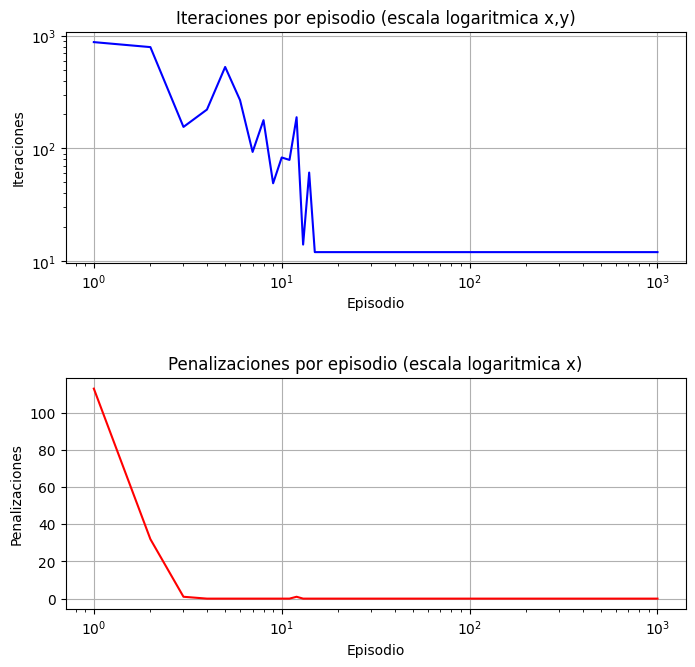

In [97]:
episodios = list(range(1, len(num_iteraciones_episodios) + 1))
    
calcular_promedios(num_iteraciones_episodios, num_penalizaciones_episodios)

plt.figure(figsize=(8, 12))

dibujar_grafico(
    episodios, 
    num_iteraciones_episodios, 
    1, 
    'Iteraciones', 
    'Iteraciones por episodio (escala logaritmica x,y)', 
    escala_log_x=True, 
    escala_log_y=True
)

dibujar_grafico(episodios,
 num_penalizaciones_episodios,
 2,
 'Penalizaciones',
 'Penalizaciones por episodio (escala logaritmica x)',
 escala_log_x=True,
 color='red',
)

plt.subplots_adjust(hspace=0.5)
plt.show()

En nuestro algoritmo, hemos implementado una **estrategia de exploración que evoluciona a lo largo del tiempo**, lo que ha demostrado ser efectivo en el proceso de aprendizaje por refuerzo. Inicialmente, favorecemos la exploración, al ponderar la selección de acciones en función del conocimiento actual del agente y variando el parámetro `k` con el número de iteraciones. Esto permite al agente realizar exploración intensiva al principio y luego cambiar gradualmente hacia la explotación de conocimientos adquiridos. 

Los vestigios de exploración se pueden ver los "picos" iniciales en la cantidad de iteraciones por episodio, esto da cuenta de la exploración intensiva que realiza el agente al principio. A medida que el agente acumula conocimiento sobre el entorno, la cantidad de iteraciones por episodio disminuye, llegado a un punto en el tiempo donde el agente se vuelve más eficiente en su toma de decisiones y la cantidad de iteraciones por episodio se estabiliza, que además coincide con la convergencia de la política óptima.

En nuestros resultados se puede observar que la **cantidad de penalizaciones disminuye** a medida que aumenta el número de episodios. Este comportamiento era esperado, ya que el agente va acumulando conocimiento sobre el entorno y aprende a evitar las acciones que conllevan penalizaciones. Además, el agente se vuelve más eficiente en su toma de decisiones, lo que se refleja en una disminución en la cantidad de iteraciones necesarias para alcanzar su objetivo.

En **comparación con el agente aleatorio**, el agente de aprendizaje por refuerzo logra reducir considerablemente la cantidad de iteraciones requeridas para alcanzar sus objetivos. Esto subraya la eficacia del aprendizaje por refuerzo en la mejora del desempeño del agente y su capacidad para tomar decisiones más informadas a lo largo del tiempo.

Para poder apreciar mejor la evolución del agente, se puede ejecutar el siguiente código que muestra la evolución del agente a lo largo de una serie de episodios de interes.

In [114]:
import numpy as np

arr = np.unique(num_iteraciones_episodios)[:10][::-1]

index_episodios = [num_iteraciones_episodios.index(x) for x in arr]

for i in index_episodios:
  delay = max(0.01, 6/len(marcos_episodios[i]))
  print_frames(marcos_episodios[i], delay=delay)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)

Iteracion: 12
Estado: 0
Accion: 5
Recompensa: 20


### Se mantiene el rendimiento si cambiamos la semilla? Por qué?

Se realizaron 34.923 iteraciones, en promedio
Se recibieron 0.785 penalizaciones, en promedio


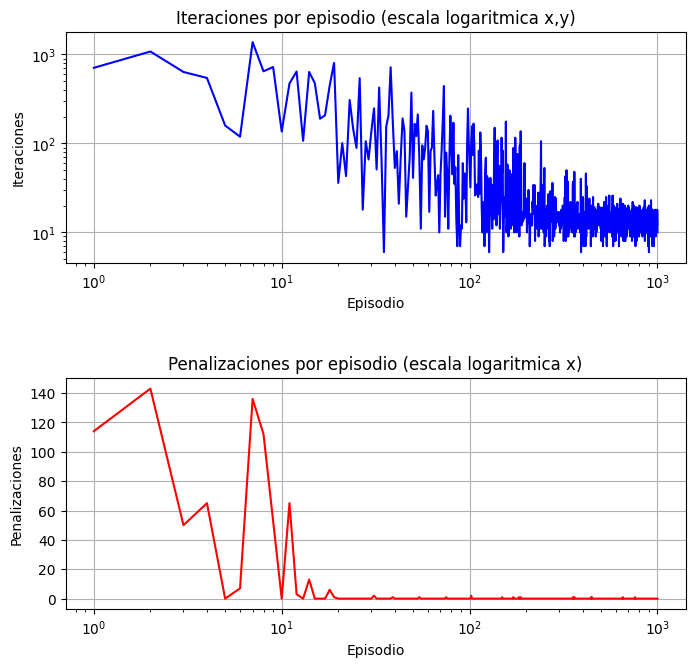

In [23]:
# Agregar código aqui
agente = AgenteRL(entorno)
num_iteraciones_episodios = []
num_penalizaciones_episodios = []
marcos_episodios = []

for i in range(1000):
    num_iteraciones, penalizaciones, marcos = ejecutar_episodio(agente, i)
    num_iteraciones_episodios += [num_iteraciones]
    num_penalizaciones_episodios += [penalizaciones]
    marcos_episodios += [marcos]

calcular_promedios(num_iteraciones_episodios, num_penalizaciones_episodios)

plt.figure(figsize=(8, 12))

dibujar_grafico(
    episodios, 
    num_iteraciones_episodios, 
    1, 
    'Iteraciones', 
    'Iteraciones por episodio (escala logaritmica x,y)', 
    escala_log_x=True, 
    escala_log_y=True
)

dibujar_grafico(episodios,
 num_penalizaciones_episodios,
 2,
 'Penalizaciones',
 'Penalizaciones por episodio (escala logaritmica x)',
 escala_log_x=True,
 color='red',
)

plt.subplots_adjust(hspace=0.5)
plt.show()

En el codigo anterior, el ambiente en el cual nuestro agente interactua es el mismo, formalmente, es un **DMDP, Deterministic Markov Decision Process**. Esto significa que el ambiente es deterministico, es decir, dado un estado y una accion, el ambiente siempre responde de la misma manera. Esto se modela facilmente en el codigo de la seccion anterior al mantener invariante la semilla.

Ahora, si en cada una de las 1000 iteraciones, cambiamos la semilla, el ambiente se vuelve **estocastico/no determinista**, es decir, dado un estado y una accion, el ambiente puede responder de diferentes maneras, dado que la composicion del entorno cambia en cada iteracion.

Esto impacta directamente en el rendimiento del agente, ya que el agente no puede converger a una politica optima. Sin embargo, la osilacion de la cantidad de iteraciones por episodio se va reduciendo a medida que el agente acumula conocimiento sobre el entorno. Esto se debe a las siguientes razones.

Por ejemplo, las paredes del entorno son invariantes a la semilla, darse contra una pared siempre conlleva una penalizacion. Por lo tanto, el agente aprende a evitar las paredes, eso se traduce en una disminucion de la cantidad de penalizaciones.

Tambien lo son las paradas, pero aqui es donde brilla la naturaliza estocastica del entorno. Dado que las paradas son invariantes a la semilla, el agente aprende a ir a las paradas, sin embargo, la ubicacion de recogida y destino cambia en cada iteracion, por lo tanto, el agente no puede converger a una politica optima. Dado que dependiendo del episodio accionar la recoleccion y entrega del pasajero puede resultar en una recompensa o una penalizacion.

### Podemos mejorar el agente para que se desempeñe bien usando cualquier semilla?

In [ ]:
# Agregar código aqui